# **Modelos Medias Moviles**
1. Implemente una clase para un modelo de medias moviles de orden q.
2. Implemente un método para inicializar el modelo. Este método recibirá un parámetro que deben ser los valores iniciales de los parámetros. En caso de que no se provea este parámetro se asignarán valores aleatorios a los valores de los parámetros.
3. Implemente un método que imprima el polinomio asociado al modelo MA.
4. Implemente un método que le permita realizar una simulación del modelo de medias moviles dados q valores iniciales y t pasos en la simulación.
5.Pruebe el funcionamiento de su clase probando los fenómenos observados en clase.

In [ ]:
import numpy as np
import pandas as pd
import re
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

In [ ]:
elctricidad = pd.read_csv("/content/consumo_electricidad.csv")
print(elctricidad)

           Fecha  Consumo_Electricidad
0     2020-01-01            506.927401
1     2020-01-02            496.326312
2     2020-01-03            495.324197
3     2020-01-04            502.001669
4     2020-01-05            503.787590
...          ...                   ...
1090  2022-12-26            554.986555
1091  2022-12-27            544.398296
1092  2022-12-28            550.527186
1093  2022-12-29            552.645713
1094  2022-12-30            554.498254

[1095 rows x 2 columns]


In [ ]:
#Haciendo estacioanria la serie de tiempo
columnas_a_escalas = ['Consumo_Electricidad']
datos_a_escalas = elctricidad[columnas_a_escalas]
escalador = StandardScaler()
datos_escalados = escalador.fit_transform(datos_a_escalas)
df_escalado = pd.DataFrame(datos_escalados, columns=columnas_a_escalas)
elctricidad_diferenciado = df_escalado.diff().dropna()

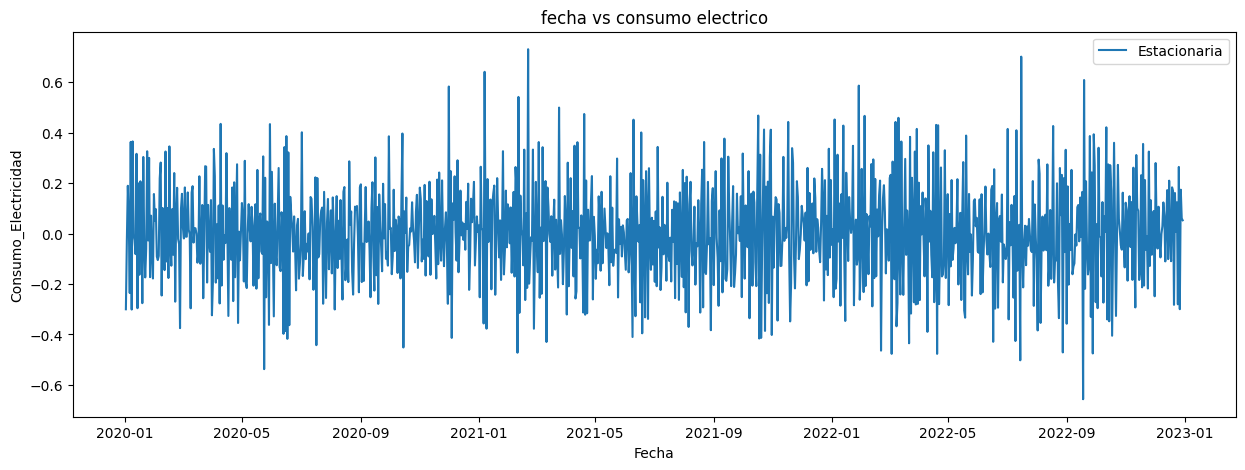

In [ ]:
elctricidad['Fecha'] = pd.to_datetime(elctricidad['Fecha'])
_fig_, _axs_ = plt.subplots(nrows = 1, figsize = (15, 5))
_fig_.subplots_adjust(hspace = 0.3, wspace = 0.3)
_axs_.set(title = "fecha vs consumo electrico")
_ = sns.lineplot(x = elctricidad["Fecha"], y = elctricidad_diferenciado['Consumo_Electricidad'], label = "Estacionaria", ax = _axs_)

In [ ]:
print(elctricidad_diferenciado)

      Consumo_Electricidad
1                -0.300205
2                -0.028378
3                 0.189094
4                 0.050574
5                -0.235797
...                    ...
1090              0.263722
1091             -0.299841
1092              0.173560
1093              0.059993
1094              0.052461

[1094 rows x 1 columns]


**1.   Implemente una clase para un modelo Medias Moviles de orden p.**

In [ ]:
#params_phi: son todos los coeficientes del modelo de orden p
#alpha_const: una constante que forma parte del modelo autoregresivo
#p es el orden del modelo
#valor_serie: caracteristicas sobre la serie de tiempo en la cual queremos hacer el modelo
#Clase del modelo autoregresivo
class ModeloMediasMoviles:

  def __init__(self, q, params_theta = None): # alpha_const = 0,

    #self.alpha_const = alpha_const
    self.q = q

    if params_theta is not None:

      self.params_theta = params_theta
    else:
      self.params_theta = np.random.rand(q)

  def modelo_mediaMovil_q(self, valor_serie,t):
    suma_val = 0
    #para los datos obserrvados dice que literalmetne se suma con la serie
    ruido = np.random.normal(0,1,len(valor_serie))

#formas de que sea una combinacion lineal:
    #wt = np.matmul(valor_serie, ruido)
    #wt = np.vstack(valor_serie,ruido )

    #opcion uno
    #wt = valor_serie + ruido

    #opcion dos
    wt = ruido

    #print(self.params_phi)
    self.params_theta= list(self.params_theta)
    for i,valor_theta in enumerate(self.params_theta):
      #comprobar que haya valores anteriores
      if t >= self.q:
        suma_val += valor_theta*wt[t-(i+1)]
    Xt = wt[0] +  suma_val
    return Xt

  def mostrar_polinomio(self, params_theta):
    self.params_theta = params_theta
    inicio_polinom =  f"X_t = 1 "
    for i, valor_theta in enumerate(self.params_theta):
      inicio_polinom += f" + {valor_theta} z**{i+1}"


    #para extraer los coeficientes de la cadena
    #coeficientes = [float(match.group(0)) for match in re.finditer(r"[-+]?\d*\.\d+|\d+", inicio_polinom)]

    #Obtener las raíces despues de haber extraido las raices
    parametros = np.flip(self.params_theta)
    parametros = list(parametros) + [1]
    print(parametros)
    parametros = np.array(parametros)
    raices = np.roots(parametros)
    return inicio_polinom, raices


  def es_invertible(self,raices):
    N=len(raices)
    suma=0
    for i in raices:
      if abs(i)>1:
        print(abs(i))
        suma+=1
    if suma==N:
      print("Es invertible")
    else:
      print("No es invertible")

  #X es el valor de la serie de tiempo
  #q es el orden
  def innovations(self, q, X):
    self.q = q
    self.X = X

    media_x = np.mean(self.X)
    autocovarianza_cero = np.mean( (self.X - media_x)**2 )

    P = np.zeros(self.q + 1)
    P[0] = autocovarianza_cero

    phi_coef = np.zeros(self.q + 1)
    phi_coef[0] = 0

    X_pred = np.zeros(len(self.X))

    for t in range(1, self.q + 1):

      sum_p = 0
      sum_teta = 0
      sum_pred_x = 0

      for j in range(1,t):

        sum_p += phi_coef[j]**2 * P[t-j-1]
        sum_teta += phi_coef[j] * phi_coef[t-j-1] * self.X[j]
        sum_pred_x += phi_coef[j-1] * (self.X[t-j] - self.X[t-1-j])

      #aplanar o dejar en unidimensional las matrices porque marcaba error sin eso, por eso el flatten
      corr = np.correlate(self.X.flatten()[:t], self.X.flatten()[:t], mode = 'valid')
      phi_coef[t-self.q] = (corr - sum_teta) /  self.X[t-1]
      P[t] = autocovarianza_cero - sum_p
      X_pred[t] = self.X[t] + sum_pred_x

    return P, phi_coef, X_pred



In [ ]:
medias_m = ModeloMediasMoviles(3 , None)
P, coef_phi, X_pred = medias_m.innovations(3, elctricidad_diferenciado)

print('P: ',P)
print('coef_phi: ',coef_phi)
print('pred; ',X_pred)

P:  [0.04005288 0.04005288 0.04005288 0.03644321]
coef_phi:  [ 0.66995509  0.         -0.30020454 -3.20415835]
pred;  [ 0.         -0.02837815  0.18909448 ...  0.          0.
  0.        ]


In [ ]:
orden_q = 2

params_theta = [0,1/3]


modelo_ma = ModeloMediasMoviles(orden_q , params_theta)

valores_pos = []
temp = list(elctricidad_diferenciado.iloc[0:1094,0])
for i in range(200):
  Xt = modelo_ma.modelo_mediaMovil_q(temp, 1094 + i)
  temp.append(Xt)
print(temp)

polinomio, raices = modelo_ma.mostrar_polinomio(params_theta)
print("Polinomio: ", polinomio)
print("Raices: ", raices)
modelo_ma.es_invertible(raices)

[-0.3002045443488054, -0.02837815051003545, 0.18909448042034627, 0.050574185158445806, -0.23579732993157054, 0.3628199343988794, -0.3012944759241891, 0.3648934998586355, -0.004692243727884682, -0.02654152100633911, -0.0816798843237182, 0.31577464545031664, -0.29599583243641847, 0.19865638934011548, -0.16354657301562386, 0.20691074493507927, 0.1786745737634014, -0.27601255502936767, 0.30325346396520403, -0.05135444935846331, -0.17395687248155228, -0.06053609450145475, 0.3258723153220636, -0.02766068953361761, 0.29943886099480876, -0.17276993801397947, 0.07068138878619033, -0.07971690871131204, -0.1782401747835091, 0.15648816788367856, 0.05085209613965934, 0.09657467670679633, -0.09156515220603334, -0.10525320127538389, -0.08874781531365826, 0.21858910684778696, 0.28112439055340366, -0.24566678073360934, 0.1011004829611073, -0.06677069553898193, -0.14503067223485785, 0.3248890852919089, -0.1107313326923951, 0.10084767050643234, -0.17628883973238824, 0.3451525218627987, -0.049090995138185

In [ ]:
params_theta = [1.9]

modelo_ma = ModeloMediasMoviles(orden_q , params_theta)

valores_pos = []
temp = list(elctricidad_diferenciado.iloc[0:1094,0])
for i in range(200):
  Xt = modelo_ma.modelo_mediaMovil_q(temp, 1094 + i)
  temp.append(Xt)
print(temp)

polinomio, raices = modelo_ma.mostrar_polinomio(params_theta)
print("Polinomio: ", polinomio)
print("Raices: ", raices)
modelo_ma.es_invertible(raices)

[-0.3002045443488054, -0.02837815051003545, 0.18909448042034627, 0.050574185158445806, -0.23579732993157054, 0.3628199343988794, -0.3012944759241891, 0.3648934998586355, -0.004692243727884682, -0.02654152100633911, -0.0816798843237182, 0.31577464545031664, -0.29599583243641847, 0.19865638934011548, -0.16354657301562386, 0.20691074493507927, 0.1786745737634014, -0.27601255502936767, 0.30325346396520403, -0.05135444935846331, -0.17395687248155228, -0.06053609450145475, 0.3258723153220636, -0.02766068953361761, 0.29943886099480876, -0.17276993801397947, 0.07068138878619033, -0.07971690871131204, -0.1782401747835091, 0.15648816788367856, 0.05085209613965934, 0.09657467670679633, -0.09156515220603334, -0.10525320127538389, -0.08874781531365826, 0.21858910684778696, 0.28112439055340366, -0.24566678073360934, 0.1011004829611073, -0.06677069553898193, -0.14503067223485785, 0.3248890852919089, -0.1107313326923951, 0.10084767050643234, -0.17628883973238824, 0.3451525218627987, -0.049090995138185

In [ ]:
# comprobacion de que sin enviar parametros funciona
modelo_ma = ModeloMediasMoviles(1)

valores_pos = []
temp = list(elctricidad_diferenciado.iloc[0:1094,0])
for i in range(200):
  Xt = modelo_ma.modelo_mediaMovil_q(temp, 1094 + i)
  temp.append(Xt)
print(temp)




[-0.3002045443488054, -0.02837815051003545, 0.18909448042034627, 0.050574185158445806, -0.23579732993157054, 0.3628199343988794, -0.3012944759241891, 0.3648934998586355, -0.004692243727884682, -0.02654152100633911, -0.0816798843237182, 0.31577464545031664, -0.29599583243641847, 0.19865638934011548, -0.16354657301562386, 0.20691074493507927, 0.1786745737634014, -0.27601255502936767, 0.30325346396520403, -0.05135444935846331, -0.17395687248155228, -0.06053609450145475, 0.3258723153220636, -0.02766068953361761, 0.29943886099480876, -0.17276993801397947, 0.07068138878619033, -0.07971690871131204, -0.1782401747835091, 0.15648816788367856, 0.05085209613965934, 0.09657467670679633, -0.09156515220603334, -0.10525320127538389, -0.08874781531365826, 0.21858910684778696, 0.28112439055340366, -0.24566678073360934, 0.1011004829611073, -0.06677069553898193, -0.14503067223485785, 0.3248890852919089, -0.1107313326923951, 0.10084767050643234, -0.17628883973238824, 0.3451525218627987, -0.049090995138185

In [ ]:
#se muestra el polinomio y las raices asociadas a este
polin, raiz = modelo_ma.mostrar_polinomio(params_theta)
print("polinomio asociado: ",polin)
print("raices obtenidas: ", raiz)

polinomio asociado:  X_t =  + 0 z**2 + 0.3333333333333333 z**1 + 1
raices obtenidas:  [-3.]


In [ ]:
params_theta = np.random.rand(1)
print(params_theta)

[0.87746535]


In [ ]:
q = 1

params_theta = [0.9]
modelo_ma_positivo_menora1 = ModeloMediasMoviles(q,params_theta)

valores_pos = []
temp = list(elctricidad_diferenciado.iloc[0:1094,0])
for i in range(200):
  Xt = modelo_ma_positivo_menora1.modelo_mediaMovil_q(temp, 1094 + i)
  temp.append(Xt)
  valores_pos.append(Xt)

In [ ]:
print(valores_pos)

[-0.9145186081231996, 0.15986533270926118, -0.016659585145507416, 0.11975048424534507, 0.6930061453659827, -0.46491585928391865, 1.1983251906044432, -1.4530271439948494, -0.050263264508717403, -2.1379191249833833, -1.6486499305725575, -0.49550712863777535, 1.2291680230600797, 3.9273088385869923, -1.283522311951881, 1.4453510430952385, 0.4526191626205017, 0.06449252965270635, -0.6590513974125632, -0.612780659206636, 2.0002686514178123, 1.2131449701265455, 1.8123556598166084, -3.2279715862917087, 0.16844086810280454, -0.2416339931868323, 0.34355671082824707, -3.051431104091632, 0.41129929247258956, 1.934512420313861, -0.8941462686177835, 2.196674070323668, -0.041649392351570974, -1.4373906608018376, -0.7273413181177009, 1.8636139464119323, -0.0580490750780966, -1.0181089592634207, 0.0197599525877567, -0.8138837853113801, 0.39646963956328185, -2.042054269244514, 1.1424996869776878, -1.5965065768718645, 1.8606921175667157, -0.22124032626821036, -1.4397812954961393, 1.1793573902910666, 0.87

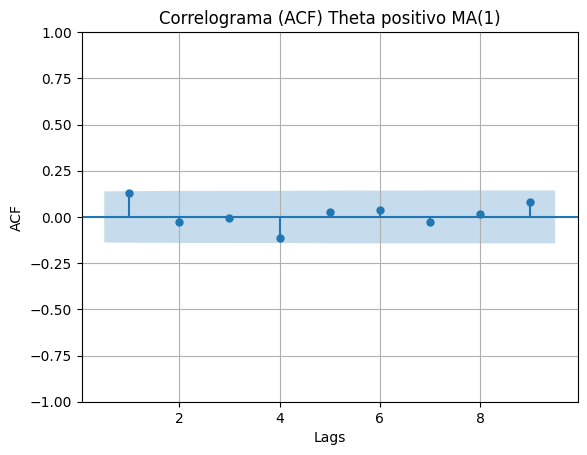

In [ ]:
plot_acf(valores_pos, lags = [1,2,3,4,5,6,7,8,9])
plt.title('Correlograma (ACF) Theta positivo MA(1)')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.grid(True)
plt.show()

In [ ]:
#negativo
q = 1

params_theta = [-0.9]
valores_neg = []
temp = list(elctricidad_diferenciado.iloc[0:1094,0])
modelo_ma_neg =  ModeloMediasMoviles(q,params_theta)
for i in range(200):
  Xt = modelo_ma_neg.modelo_mediaMovil_q(temp, 1094 + i)
  temp.append(Xt)
  valores_neg.append(Xt)

In [ ]:
print(valores_neg)

[3.2531366677348954, -0.6781599918964457, 2.9391330378485137, -1.7218976698437005, 1.5581921710891278, -0.999235826067673, -0.0015398089940076298, -0.49925032161679805, -0.6403057777564417, 0.5392166908820148, -0.44702833760259986, 0.3090662376882795, -1.7883479049741542, -1.2470046705519822, 0.8803043376990478, -0.19188276887601408, -1.8274745131109753, 0.707141879315986, 1.3409335997508747, -2.403867796790758, -2.0863512926644, -1.5492001283102201, 0.0837441379123981, -0.756512849755616, 1.723164015940374, 0.4984464486176075, 1.5603439955037535, -0.21110083273997482, -1.033363578245673, 0.25501267487534474, 0.7848051375039661, 1.3673540332910452, 1.8383849578870646, -1.1860646643882822, 0.21475132952391982, -2.220003253580207, -3.871915440231865, 1.08392808976393, -1.3321227583045185, -0.3709707723636004, -0.6108442747051617, -0.44855395192495306, 1.1213974164817158, -1.4694553477527097, -1.7481345967813662, 0.39867800661638575, 0.30847754657798204, 0.5077537965056181, 2.363127854149

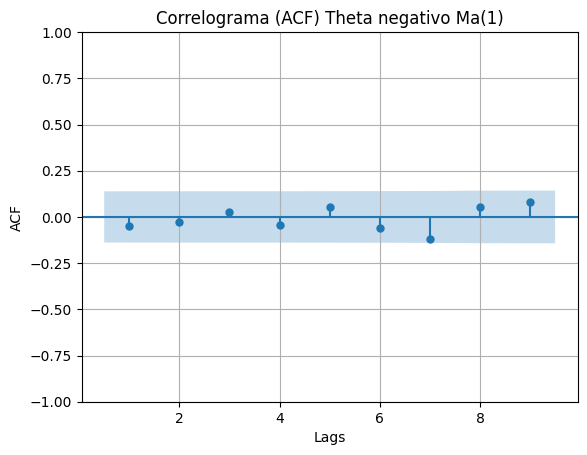

In [ ]:
#plot_acf(valores_neg, lags = 30)
plot_acf(valores_neg, lags = [1,2,3,4,5,6,7,8,9])

plt.title('Correlograma (ACF) Theta negativo Ma(1)')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.grid(True)
plt.show()

In [ ]:
#mayor a uno
q = 1
params_phi_m = [1.9]
valores_mayor = []
temp = list(elctricidad_diferenciado.iloc[0:1094,0])
modelo_may_may = ModeloMediasMoviles(q,params_theta)
for i in range(200):
  Xt = modelo_ma.modelo_mediaMovil_q(temp, 1094 + i)
  temp.append(Xt)
  valores_mayor.append(Xt)

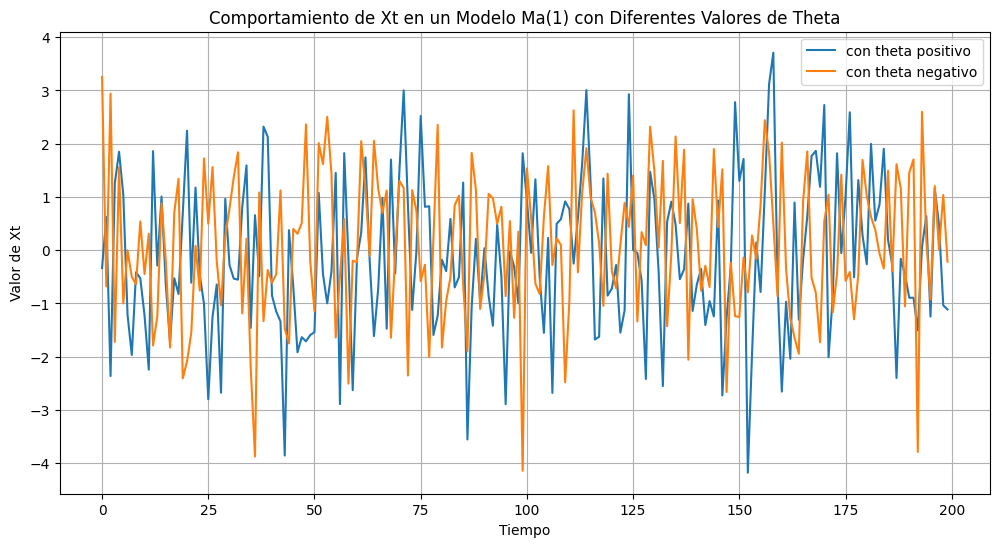

In [ ]:
# Crear una lista de tiempo con la misma longitud en todos los casos
tiempo = list(range(199 + 1))

# Graficar las predicciones en los tres casos
plt.figure(figsize=(12, 6))
plt.plot(tiempo, valores_pos, label="con theta positivo")
plt.plot(tiempo, valores_neg, label="con theta negativo")
#plt.plot(tiempo, valores_mayor, label="con phi mayor a 1")
plt.xlabel("Tiempo")
plt.ylabel("Valor de Xt")
plt.title("Comportamiento de Xt en un Modelo Ma(1) con Diferentes Valores de Theta")
plt.legend()
plt.grid()
plt.show()

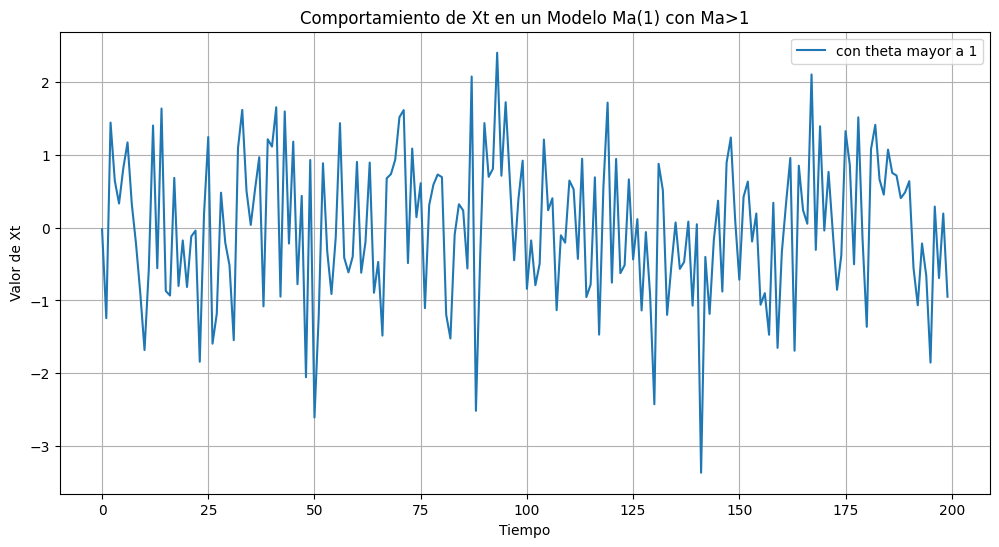

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(tiempo, valores_mayor, label="con theta mayor a 1")
plt.xlabel("Tiempo")
plt.ylabel("Valor de Xt")
plt.title("Comportamiento de Xt en un Modelo Ma(1) con Ma>1")
plt.legend()
plt.grid()
plt.show()